In [23]:
#导入必要的包
import os
import paddle
import paddle.fluid as fluid
import numpy as np
from PIL import Image
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
import zipfile
import random
import json
import sys
from PIL import ImageEnhance
from paddle.fluid import ParamAttr

In [45]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 100, 100],                              #输入图片的shape
    "class_dim": 5,                                          #分类数
    "src_path": r"C:\Study_\data\data18736\\face_data_5.zip",  #原始数据集路径
    "target_path": r"C:\Study_\\face_data_5",                  #要解压的路径
    "train_list_path": r"C:\Study_\data\\train.txt",            #train.txt路径
    "eval_list_path": r"C:\Study_\data\eval.txt",               #eval.txt路径
    "readme_path": r"C:\Study_\data\\readme.json",              #readme.json路径
    "label_dict":{},                                          #标签字典
    "num_epochs": 55,                                         #训练轮数
    "train_batch_size": 30,                                    #训练时每个批次的大小
    "learning_strategy": {                                    #优化函数相关的配置
        "lr": 0.0007                                        #超参数学习率
    } 
}

In [26]:
src_path=train_parameters["src_path"]
target_path=train_parameters["target_path"]
if(not os.path.isdir(target_path)):
    z = zipfile.ZipFile(src_path, 'r')
    z.extractall(path=target_path)
    z.close()

In [27]:
def data_mapper(data):
    img, label = data
    img = paddle.dataset.image.load_and_transform(img,100,100, False).astype('float32')#img.shape是(3, 100, 100)
    img = img / 255.0 
    # img = paddle.dataset.image.load_image(img)       
    #将img数组进行进行归一化处理，得到0到1之间的数值
    return img, int(label)

def data_reader(data_path, buffered_size=512):
  print(data_path)
  def reader():
      for image in os.listdir(data_path):
          label = int(image.split('-')[0]) - 1
          img = os.path.join(data_path+ '/' + image)
          yield img, label
  return paddle.reader.xmap_readers(data_mapper, reader, cpu_count(), buffered_size)

In [41]:
#构造训练、测试数据提供器
BATCH_SIZE = train_parameters["train_batch_size"]
train_r = data_reader(data_path=r'C:\Study_\\face_data_5\\face_data_5\\face_image_train')
train_reader = paddle.batch(paddle.reader.shuffle(reader=train_r,buf_size=128),batch_size=BATCH_SIZE)
test_r= data_reader(data_path=r'C:\Study_\\face_data_5\\face_data_5\\face_image_test')
test_reader = paddle.batch(test_r, batch_size=BATCH_SIZE)
print(next(test_reader()))

C:\Study_\\face_data_5\\face_data_5\\face_image_train
C:\Study_\\face_data_5\\face_data_5\\face_image_test
[(array([[[0.25882354, 0.25490198, 0.34509805, ..., 0.11372549,
         0.16862746, 0.17254902],
        [0.2509804 , 0.25882354, 0.34117648, ..., 0.14509805,
         0.14901961, 0.17254902],
        [0.25490198, 0.2901961 , 0.34901962, ..., 0.15686275,
         0.14117648, 0.16078432],
        ...,
        [0.24313726, 0.25882354, 0.16078432, ..., 0.76862746,
         0.77254903, 0.9529412 ],
        [0.32156864, 0.31764707, 0.36078432, ..., 0.98039216,
         0.99215686, 0.9843137 ],
        [0.42745098, 0.3254902 , 0.59607846, ..., 1.        ,
         0.9882353 , 0.95686275]],

       [[0.25882354, 0.24705882, 0.3372549 , ..., 0.12156863,
         0.16078432, 0.15686275],
        [0.24705882, 0.25882354, 0.34117648, ..., 0.15294118,
         0.14117648, 0.15686275],
        [0.24313726, 0.28235295, 0.34901962, ..., 0.16078432,
         0.14117648, 0.14509805],
        ...,

In [29]:
class ConvBnLayer(fluid.dygraph.Layer):
    """
    卷积 + batch_normal 层
    
    """
    def __init__(self, num_channels, num_filters, filter_size, stride=1,
                 padding=0, act="relu"):
        super(ConvBnLayer, self).__init__()

        self._conv2d = fluid.dygraph.Conv2D(
            num_channels=num_channels,
            num_filters=num_filters,
            filter_size=filter_size,
            stride=stride,
            padding=padding)

        self._batch_normal = fluid.dygraph.BatchNorm(
            num_channels=num_filters,
            act=act,
            param_attr=ParamAttr(),
            bias_attr=ParamAttr()
        )

    def forward(self, inputs):
        x = self._conv2d(inputs)
        x = self._batch_normal(x)
        return x

In [30]:
class ConvPool(fluid.dygraph.Layer):
    '''卷积+池化'''
    def __init__(self,
                 num_channels,
                 num_filters,
                 filter_size,
                 pool_size,
                 pool_stride,
                 groups,
                 pool_padding=0,
                 pool_type='max',
                 conv_stride=1,
                 conv_padding=0,
                 act='relu'):
        super(ConvPool, self).__init__()  

        self._conv2d_list = []

        for i in range(groups):
            conv2d = self.add_sublayer(   #返回一个由所有子层组成的列表。
                'bb_%d' % i,
                ConvBnLayer(
                    num_channels=num_channels, #通道数
                    num_filters=num_filters,   #卷积核个数
                    filter_size=filter_size,   #卷积核大小
                    stride=conv_stride,        #步长
                    padding=conv_padding,      #padding大小，默认为0
                    act=act
                )
            )
        self._conv2d_list.append(conv2d) 
        
          

        self._pool2d = fluid.dygraph.Pool2D(
            pool_size=pool_size,           #池化核大小
            pool_type=pool_type,           #池化类型，默认是最大池化
            pool_stride=pool_stride,       #池化步长
            pool_padding=pool_padding      #填充大小
            )

    def forward(self, inputs):
        x = inputs
        for conv in self._conv2d_list:
            x = conv(x)
        x = self._pool2d(x)
        return x

In [31]:
class VGGNet(fluid.dygraph.Layer):
    '''
    VGG网络
    '''
    def __init__(self):
        super(VGGNet, self).__init__()
        self.conv1 = ConvPool(3, 64, 3, 2, 2, 2, act='relu')
        self.conv2  = ConvPool(64, 128, 3, 2, 2, 2, act='relu')
        self.conv3  = ConvPool(128, 256, 3, 2, 2, 3, act='relu')
        self.conv4  = ConvPool(256, 512, 3, 2, 2, 3, act='relu')
        self.conv5  = ConvPool(512, 512, 3, 2, 2, 3, act='relu')
        self.fc1 = fluid.dygraph.Linear(input_dim=512, output_dim=512, act='relu')
        self.fc2 = fluid.dygraph.Linear(input_dim=512, output_dim=512, act='relu')
        self.fc3 = fluid.dygraph.Linear(input_dim=512, output_dim=5, act='softmax')
       

    def forward(self, inputs, label=None):
        """前向计算"""
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = fluid.layers.reshape(x, [x.shape[0], -1])

        x= fluid.layers.dropout(x, 0.5)

        x = self.fc1(x)
        x= fluid.layers.dropout(x, 0.5)
        x = self.fc2(x)
        x= fluid.layers.dropout(x, 0.5)
        y = self.fc3(x)

        if label is not None:
            acc = fluid.layers.accuracy(input=y, label=label)
            return y, acc

        return y

In [32]:
def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()

In [33]:
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

5
learning-rate: 0.0007
Loss at epoch 0 step 0: [1.6245775], acc: [0.22222222]
Loss at epoch 0 step 20: [0.8983956], acc: [0.6111111]
learning-rate: 0.0007
Loss at epoch 1 step 0: [1.4133778], acc: [0.]
Loss at epoch 1 step 20: [0.73007286], acc: [1.]
learning-rate: 0.0007
Loss at epoch 2 step 0: [1.2703304], acc: [0.]
Loss at epoch 2 step 20: [0.76079273], acc: [0.7222222]
learning-rate: 0.0007
Loss at epoch 3 step 0: [0.9805029], acc: [0.05555556]
Loss at epoch 3 step 20: [0.8525508], acc: [0.44444445]
learning-rate: 0.0007
Loss at epoch 4 step 0: [0.9154944], acc: [0.22222222]
Loss at epoch 4 step 20: [0.7772036], acc: [0.5555556]
learning-rate: 0.0007
Loss at epoch 5 step 0: [0.9570187], acc: [0.11111111]
Loss at epoch 5 step 20: [0.808812], acc: [0.5]
learning-rate: 0.0007
Loss at epoch 6 step 0: [0.9116469], acc: [0.05555556]
Loss at epoch 6 step 20: [0.846151], acc: [0.44444445]
learning-rate: 0.0007
Loss at epoch 7 step 0: [0.8805839], acc: [0.22222222]
Loss at epoch 7 step 20:

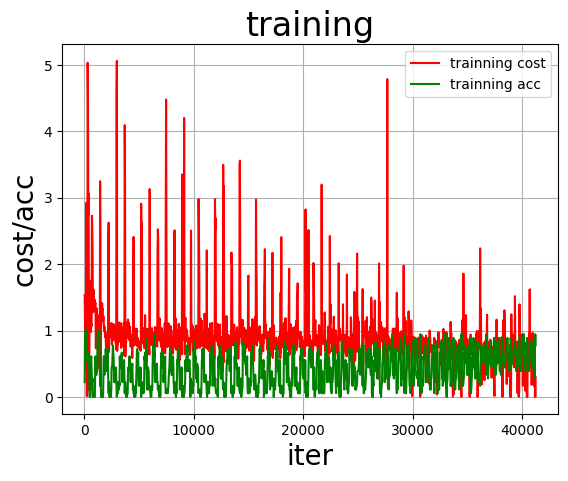

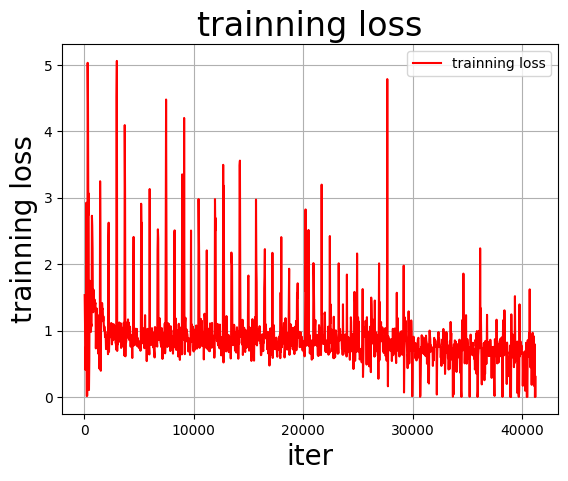

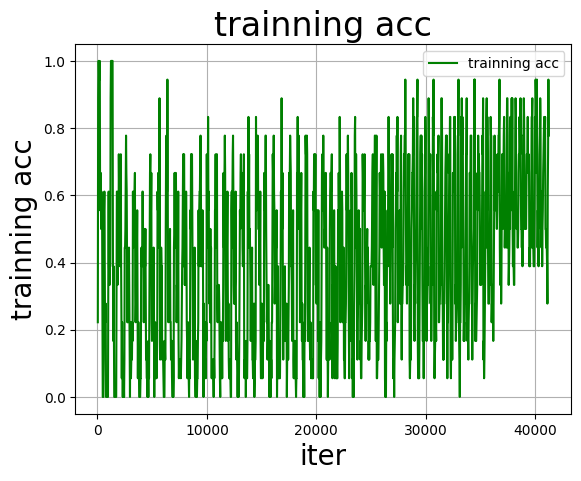

Final loss: [0.18753535], Best test acc : 0.5555555820465088


In [46]:
'''
模型训练
'''

all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

model_save_dir = r"C:\Study_\work\\"
best_test_acc = 0.0
with fluid.dygraph.guard(place = fluid.CUDAPlace(0)):
#with fluid.dygraph.guard():
    print(train_parameters['class_dim'])
    vgg = VGGNet()
    vgg.train()
    optimizer=fluid.optimizer.AdamOptimizer(learning_rate=fluid.dygraph.ExponentialDecay(
              learning_rate=train_parameters['learning_strategy']['lr'],
              decay_steps=1200,
              decay_rate=0.3,
              staircase=True),parameter_list=vgg.parameters()) 
              
    for epoch_num in range(train_parameters['num_epochs']):
        lr = optimizer.current_step_lr()
        print("learning-rate:", lr)

        for batch_id, data in enumerate(train_reader()):
            dy_x_data = np.array([x[0] for x in data]).astype('float32')           
            y_data = np.array([x[1] for x in data]).astype('int64')      
            y_data = y_data[:, np.newaxis]

            #将Numpy转换为DyGraph接收的输入
            img = fluid.dygraph.to_variable(dy_x_data)
            label = fluid.dygraph.to_variable(y_data)

            out,acc = vgg(img,label)
            loss = fluid.layers.cross_entropy(out, label)
            avg_loss = fluid.layers.mean(loss)

            #使用backward()方法可以执行反向网络
            avg_loss.backward()
            optimizer.minimize(avg_loss)
             
            #将参数梯度清零以保证下一轮训练的正确性
            vgg.clear_gradients()
            

            all_train_iter=all_train_iter+train_parameters['train_batch_size']
            all_train_iters.append(all_train_iter)
            all_train_costs.append(loss.numpy()[0])
            all_train_accs.append(acc.numpy()[0])
                
            if batch_id % 20 == 0:
                print("Loss at epoch {} step {}: {}, acc: {}".format(epoch_num, batch_id, avg_loss.numpy(), acc.numpy()))


with fluid.dygraph.guard(place = fluid.CUDAPlace(0)):
    accs = []
    vgg.eval()#评估模式
    for batch_id,data in enumerate(test_reader()):#测试集
        images=np.array([x[0].reshape(3,100,100) for x in data],np.float32)
        labels = np.array([x[1] for x in data]).astype('int64')
        labels = labels[:, np.newaxis]
    
        image=fluid.dygraph.to_variable(images)
        label=fluid.dygraph.to_variable(labels)
    
        predict=vgg(image)#预测
        acc=fluid.layers.accuracy(predict,label)
        accs.append(acc.numpy()[0])
        avg_acc = np.mean(accs)
    
    
    if avg_acc >= best_test_acc:
        best_test_acc = avg_acc
        
        fluid.save_dygraph(vgg.state_dict(), model_save_dir + "vgg")#保存模型 
    
    print('Test:%d, Accuracy:%0.5f, Best: %0.5f'%  (epoch_num, avg_acc, best_test_acc))

draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")  
draw_process("trainning loss","red",all_train_iters,all_train_costs,"trainning loss")
draw_process("trainning acc","green",all_train_iters,all_train_accs,"trainning acc")  


print("Final loss: {}, Best test acc : {}".format(avg_loss.numpy(), best_test_acc))

In [17]:

#图片预处理
def load_image(file):
    im = Image.open(file)
    im = im.resize((100, 100), Image.ANTIALIAS)                 #resize image with high-quality 图像大小为128*128
    im = np.array(im).reshape(1, 3, 100, 100).astype(np.float32)#返回新形状的数组,把它变成一个 numpy 数组以匹配数据馈送格式。
    im = im / 255.0                            #归一化到【-1~1】之间
    return im

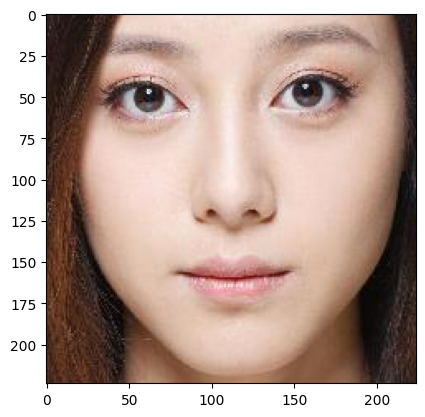

results Tensor(shape=[1, 5], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [[0.00291614, 0.34790370, 0.38048503, 0.07941919, 0.18927594]])
infer results: 3


c:\ProgramData\miniconda3\envs\work\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  after removing the cwd from sys.path.


In [22]:
label_list = ["1", "2", "3", "4", "5"]

infer_path = r'C:\Study_\\face_data_5\\face_data_5\\face_image_test\\4-46.jpg'
img = Image.open(infer_path)
plt.imshow(img)   
plt.show()    


#构建预测动态图过程

with fluid.dygraph.guard():
    vgg = VGGNet()#模型实例化
    model_dict,_=fluid.load_dygraph(model_save_dir + "vgg")
    vgg.load_dict(model_dict)#加载模型参数
    vgg.eval()#评估模式

    infer_img = load_image(infer_path)
    infer_img=np.array(infer_img).astype('float32')
    infer_img = fluid.dygraph.to_variable(infer_img)
    result=vgg(infer_img)
    print('results',result)
   
    print("infer results: %s" % label_list[np.argmax(result.numpy())])